In [1]:
import os
import cv2
import pandas as pd
from scipy.io import loadmat
import mediapipe as mp
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
dataset_folder = 'C:/Users/Electronica Care/AFLW2000'

In [3]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Use 7 key landmarks
selected_landmarks = [1, 33, 263, 10, 234, 454, 152]

columns = ["image_name", "pitch", "yaw", "roll"] + \
          [f"landmark_{i}x" for i in selected_landmarks] + \
          [f"landmark_{i}y" for i in selected_landmarks]

df = pd.DataFrame(columns=columns)

In [4]:
for file_name in os.listdir(dataset_folder):
    if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(dataset_folder, file_name)
        mat_path = os.path.join(dataset_folder, os.path.splitext(file_name)[0] + ".mat")

        data = loadmat(mat_path)
        pose_para = data["Pose_Para"][0][:3]
        pitch, yaw, roll = np.degrees(pose_para[0]), np.degrees(pose_para[1]), np.degrees(pose_para[2])

        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = face_mesh.process(image_rgb)
        landmarks_x, landmarks_y = [None]*len(selected_landmarks), [None]*len(selected_landmarks)

        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            for idx, lm_index in enumerate(selected_landmarks):
                lm = face_landmarks.landmark[lm_index]
                landmarks_x[idx] = lm.x
                landmarks_y[idx] = lm.y

        row = [file_name, pitch, yaw, roll] + landmarks_x + landmarks_y
        df.loc[len(df)] = row

C:\Users\Electronica Care\AppData\Local\Temp\ipykernel_17296\894707679.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = row
C:\Users\Electronica Care\AppData\Local\Temp\ipykernel_17296\894707679.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = row
C:\Users\Electronica Care\AppData\Local\Temp\ipykernel_17296\894707679.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will 

In [5]:
df.dropna(axis=0, how='any', inplace=True)
df.to_csv("dataset_features_7points.csv", index=False)
print("Saved dataset_features_7points.csv with 7 landmarks!")

Saved dataset_features_7points.csv with 7 landmarks!


In [6]:
df.head()

,image_name,pitch,yaw,roll,landmark_1x,landmark_33x,landmark_263x,landmark_10x,landmark_234x,landmark_454x,landmark_152x,landmark_1y,landmark_33y,landmark_263y,landmark_10y,landmark_234y,landmark_454y,landmark_152y
0,image00002.jpg,-22.874237,1.044306,4.908885,0.489194,0.354743,0.669544,0.521101,0.285935,0.749692,0.482630,0.639722,0.441597,0.473942,0.295806,0.449545,0.497433,0.827571
1,image00004.jpg,26.932741,68.155235,17.243670,0.417273,0.466445,0.590615,0.488381,0.535930,0.749114,0.488959,0.592251,0.498001,0.503390,0.390755,0.543560,0.560876,0.752465
2,image00006.jpg,-10.579652,50.485409,-13.570644,0.321328,0.242887,0.375262,0.312070,0.198428,0.397786,0.315575,0.776498,0.716360,0.713755,0.647554,0.735856,0.733074,0.873942
3,image00008.jpg,-10.048455,17.143373,-21.392782,0.469521,0.355064,0.601773,0.407994,0.371525,0.727550,0.578915,0.653913,0.536397,0.456452,0.381680,0.560290,0.445205,0.804325
5,image00013.jpg,-1.536199,0.685565,-12.643007,0.492729,0.351501,0.608139,0.444616,0.298911,0.710184,0.550432,0.604797,0.510302,0.455517,0.330580,0.593865,0.502793,0.826267


In [7]:
X_raw = df.filter(like="landmark").apply(pd.to_numeric, errors="coerce").dropna()

In [68]:
X_raw.head()

,landmark_1x,landmark_33x,landmark_263x,landmark_10x,landmark_234x,landmark_454x,landmark_152x,landmark_1y,landmark_33y,landmark_263y,landmark_10y,landmark_234y,landmark_454y,landmark_152y
0,0.489194,0.354743,0.669544,0.521101,0.285935,0.749692,0.482630,0.639722,0.441597,0.473942,0.295806,0.449545,0.497433,0.827571
1,0.417273,0.466445,0.590615,0.488381,0.535930,0.749114,0.488959,0.592251,0.498001,0.503390,0.390755,0.543560,0.560876,0.752465
2,0.321328,0.242887,0.375262,0.312070,0.198428,0.397786,0.315575,0.776498,0.716360,0.713755,0.647554,0.735856,0.733074,0.873942
3,0.469521,0.355064,0.601773,0.407994,0.371525,0.727550,0.578915,0.653913,0.536397,0.456452,0.381680,0.560290,0.445205,0.804325
5,0.492729,0.351501,0.608139,0.444616,0.298911,0.710184,0.550432,0.604797,0.510302,0.455517,0.330580,0.593865,0.502793,0.826267


In [8]:
def normalize_features(row):
    nose_x, nose_y = row["landmark_1x"], row["landmark_1y"]
    eye_left_x, eye_left_y = row["landmark_33x"], row["landmark_33y"]
    eye_right_x, eye_right_y = row["landmark_263x"], row["landmark_263y"]

    eye_dist = np.sqrt((eye_right_x - eye_left_x)**2 + (eye_right_y - eye_left_y)**2)
    if eye_dist == 0: eye_dist = 1e-6

    feats = []
    for i in selected_landmarks:
        x, y = row[f"landmark_{i}x"], row[f"landmark_{i}y"]
        feats.append((x - nose_x) / eye_dist)
        feats.append((y - nose_y) / eye_dist)

    return pd.Series(feats)

In [9]:
X = X_raw.apply(normalize_features, axis=1)
y_pitch = df.loc[X.index, "pitch"]
y_yaw   = df.loc[X.index, "yaw"]
y_roll  = df.loc[X.index, "roll"]

In [10]:
X_train, X_test, y_pitch_train, y_pitch_test, y_yaw_train, y_yaw_test, y_roll_train, y_roll_test = train_test_split(
    X, y_pitch, y_yaw, y_roll, test_size=0.2, random_state=42
)

In [11]:
def build_rf():
    return RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

In [12]:
pitch_model = build_rf()
yaw_model   = build_rf()
roll_model  = build_rf()

pitch_model.fit(X_train, y_pitch_train)
yaw_model.fit(X_train, y_yaw_train)
roll_model.fit(X_train, y_roll_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
for name, model, y_true, y_pred in [
    ("Pitch", pitch_model, y_pitch_test, pitch_model.predict(X_test)),
    ("Yaw", yaw_model, y_yaw_test, yaw_model.predict(X_test)),
    ("Roll", roll_model, y_roll_test, roll_model.predict(X_test))
]:
    print(f"{name} -> MAE: {mean_absolute_error(y_true, y_pred):.4f}, "
          f"MSE: {mean_squared_error(y_true, y_pred):.4f}, "
          f"R²: {r2_score(y_true, y_pred):.4f}")

Pitch -> MAE: 5.3532, MSE: 75.5437, R²: 0.6847
Yaw -> MAE: 4.0520, MSE: 56.8979, R²: 0.9315
Roll -> MAE: 4.7957, MSE: 255.9960, R²: 0.2261


In [14]:
cv_scores_pitch = cross_val_score(pitch_model, X_train, y_pitch_train, cv=5, scoring="r2")
print("Pitch CV R²:", cv_scores_pitch.mean())

Pitch CV R²: 0.36156489371609213


In [28]:
def draw_pose_axes(img, pitch, yaw, roll, nose_point, length=100):
    pitch = -pitch
    h, w, _ = img.shape
    cx, cy = int(nose_point[0] * w), int(nose_point[1] * h)

    pitch, yaw, roll = np.radians([pitch, yaw, roll])
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(pitch), -np.sin(pitch)],
                    [0, np.sin(pitch),  np.cos(pitch)]])
    R_y = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                    [0, 1, 0],
                    [-np.sin(yaw), 0, np.cos(yaw)]])
    R_z = np.array([[np.cos(roll), -np.sin(roll), 0],
                    [np.sin(roll),  np.cos(roll), 0],
                    [0, 0, 1]])
    R = R_z @ R_y @ R_x

    axis_x = R @ np.array([length, 0, 0])
    axis_y = R @ np.array([0, -length, 0])
    axis_z = R @ np.array([0, 0, -length])

    def project(pt): return int(cx + pt[0]), int(cy + pt[1])
    x2, y2, z2 = project(axis_x), project(axis_y), project(axis_z)

    cv2.arrowedLine(img, (cx, cy), x2, (0, 0, 255), 3)   # roll → red
    cv2.arrowedLine(img, (cx, cy), y2, (0, 255, 0), 3)   # pitch → green
    cv2.arrowedLine(img, (cx, cy), z2, (255, 0, 0), 3)   # yaw → blue

    return img

In [29]:
def predict_pose(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Image not found:", image_path)
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        print("No face detected!")
        return image

    face_landmarks = results.multi_face_landmarks[0]
    nose = face_landmarks.landmark[1]
    eye_left, eye_right = face_landmarks.landmark[33], face_landmarks.landmark[263]

    eye_dist = np.sqrt((eye_right.x - eye_left.x)**2 + (eye_right.y - eye_left.y)**2)
    if eye_dist == 0: eye_dist = 1e-6

    feats = []
    for idx in selected_landmarks:
        lm = face_landmarks.landmark[idx]
        feats.append((lm.x - nose.x) / eye_dist)
        feats.append((lm.y - nose.y) / eye_dist)

    feats = np.array(feats).reshape(1, -1)

    pitch = pitch_model.predict(feats)[0]
    yaw   = yaw_model.predict(feats)[0]
    roll  = roll_model.predict(feats)[0]

    print(f"Predicted -> Pitch: {pitch:.2f}, Yaw: {yaw:.2f}, Roll: {roll:.2f}")

    nose_point = (nose.x, nose.y)
    return draw_pose_axes(image.copy(), pitch, yaw, roll, nose_point)

Predicted -> Pitch: -16.43, Yaw: 18.90, Roll: -2.58


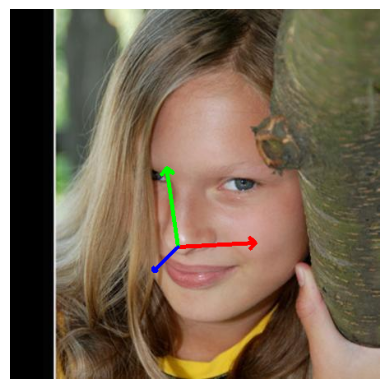

In [30]:
test_image = "C:/Users/Electronica Care/AFLW2000/image01933.jpg"
output_img = predict_pose(test_image)

if output_img is not None:
    cv2.imwrite("predicted_pose_rf.jpg", output_img)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

Predicted -> Pitch: 0.44, Yaw: 54.02, Roll: -16.82


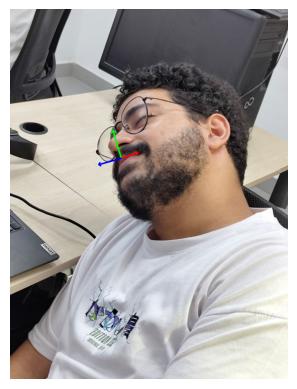

In [70]:
test_image = "C:/Users/Electronica Care/Desktop/Shawqi1.jpg"
output_img = predict_pose(test_image)

if output_img is not None:
    cv2.imwrite("predicted_pose_rf.jpg", output_img)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

Predicted -> Pitch: 39.49, Yaw: 32.56, Roll: -41.00


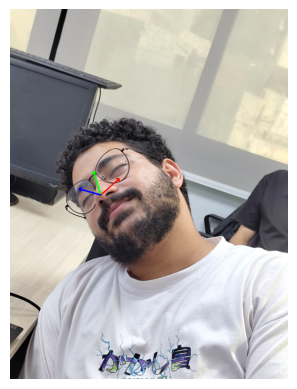

In [32]:
test_image = "C:/Users/Electronica Care/Desktop/Shawqi2.jpg"
output_img = predict_pose(test_image)

if output_img is not None:
    cv2.imwrite("predicted_pose_rf.jpg", output_img)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

Predicted -> Pitch: 1.90, Yaw: 43.11, Roll: -4.08


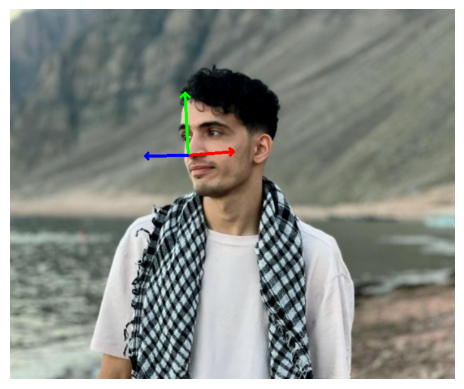

In [33]:
test_image = "C:/Users/Electronica Care/Desktop/Balta.jpg"
output_img = predict_pose(test_image)

if output_img is not None:
    cv2.imwrite("predicted_pose_rf.jpg", output_img)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

Predicted -> Pitch: 11.29, Yaw: 3.49, Roll: -2.00


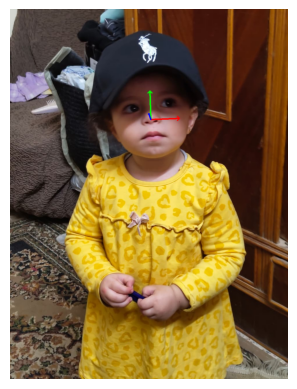

In [36]:
test_image = "C:/Users/Electronica Care/Desktop/Zozo.jpg"
output_img = predict_pose(test_image)

if output_img is not None:
    cv2.imwrite("predicted_pose_rf.jpg", output_img)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [46]:
from collections import deque
import numpy as np

class PoseSmoother:
    def __init__(self, window=5):
        self.pitch_hist = deque(maxlen=window)
        self.yaw_hist = deque(maxlen=window)
        self.roll_hist = deque(maxlen=window)

    def update(self, pitch, yaw, roll):
        self.pitch_hist.append(pitch)
        self.yaw_hist.append(yaw)
        self.roll_hist.append(roll)

        smooth_pitch = np.mean(self.pitch_hist)
        smooth_yaw   = np.mean(self.yaw_hist)
        smooth_roll  = np.mean(self.roll_hist)
        return smooth_pitch, smooth_yaw, smooth_roll

In [51]:
def process_video(video_path, output_path, frame_skip=2, smooth_window=5):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file:", video_path)
        return

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width, height = int(cap.get(3)), int(cap.get(4))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    smoother = PoseSmoother(window=smooth_window)

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1

        if frame_count % frame_skip != 0:
            continue

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]

            # === SAME as predict_pose ===
            nose = face_landmarks.landmark[1]
            eye_left, eye_right = face_landmarks.landmark[33], face_landmarks.landmark[263]

            eye_dist = np.sqrt((eye_right.x - eye_left.x)**2 + (eye_right.y - eye_left.y)**2)
            if eye_dist == 0: 
                eye_dist = 1e-6

            feats = []
            for idx in selected_landmarks:
                lm = face_landmarks.landmark[idx]
                feats.append((lm.x - nose.x) / eye_dist)
                feats.append((lm.y - nose.y) / eye_dist)

            feats = np.array(feats).reshape(1, -1)

            # Predictions
            pitch = pitch_model.predict(feats)[0]
            yaw   = yaw_model.predict(feats)[0]
            roll  = roll_model.predict(feats)[0]

            # Smooth predictions
            pitch, yaw, roll = smoother.update(pitch, yaw, roll)

            nose_point = (nose.x, nose.y)
            frame = draw_pose_axes(frame, pitch, yaw, roll, nose_point)

        out.write(frame)

    cap.release()
    out.release()
    print("Processed video saved to:", output_path)


In [53]:
video_path = "C:/Users/Electronica Care/Desktop/Video3.mp4"
output_path = "C:/Users/Electronica Care/Desktop/pose_estimation_output.avi"
process_video(video_path, output_path, frame_skip=2)

Processed video saved to: C:/Users/Electronica Care/Desktop/pose_estimation_output.avi


In [54]:
video_path = "C:/Users/Electronica Care/Desktop/Video2.mp4"
output_path = "C:/Users/Electronica Care/Desktop/pose_estimation_output1.avi"
process_video(video_path, output_path, frame_skip=2)

Processed video saved to: C:/Users/Electronica Care/Desktop/pose_estimation_output1.avi


In [55]:
video_path = "C:/Users/Electronica Care/Desktop/Video1.mp4"
output_path = "C:/Users/Electronica Care/Desktop/pose_estimation_output2.avi"
process_video(video_path, output_path, frame_skip=2)

Processed video saved to: C:/Users/Electronica Care/Desktop/pose_estimation_output2.avi


In [56]:
video_path = "C:/Users/Electronica Care/Desktop/Video4.mp4"
output_path = "C:/Users/Electronica Care/Desktop/pose_estimation_output3.avi"
process_video(video_path, output_path, frame_skip=2)

Processed video saved to: C:/Users/Electronica Care/Desktop/pose_estimation_output3.avi


In [58]:
video_path = "C:/Users/Electronica Care/Desktop/Zizo3.mp4"
output_path = "C:/Users/Electronica Care/Desktop/pose_estimation_output3.avi"
process_video(video_path, output_path, frame_skip=2)

Processed video saved to: C:/Users/Electronica Care/Desktop/pose_estimation_output3.avi


In [69]:
video_path = "C:/Users/Electronica Care/Desktop/Video8.mp4"
output_path = "C:/Users/Electronica Care/Desktop/pose_estimation_output3.avi"
process_video(video_path, output_path, frame_skip=2)

Processed video saved to: C:/Users/Electronica Care/Desktop/pose_estimation_output3.avi


In [59]:
def realtime_pose_prediction(frame_skip=2, smooth_window=5):
    cap = cv2.VideoCapture(0)  # 0 = default webcam
    if not cap.isOpened():
        print("Error: Cannot access camera")
        return

    smoother = PoseSmoother(window=smooth_window)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        frame_count += 1

        # Skip frames if needed (to save CPU/GPU)
        if frame_count % frame_skip != 0:
            continue

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]

            # === SAME normalization as predict_pose ===
            nose = face_landmarks.landmark[1]
            eye_left, eye_right = face_landmarks.landmark[33], face_landmarks.landmark[263]

            eye_dist = np.sqrt((eye_right.x - eye_left.x)**2 + (eye_right.y - eye_left.y)**2)
            if eye_dist == 0:
                eye_dist = 1e-6

            feats = []
            for idx in selected_landmarks:
                lm = face_landmarks.landmark[idx]
                feats.append((lm.x - nose.x) / eye_dist)
                feats.append((lm.y - nose.y) / eye_dist)

            feats = np.array(feats).reshape(1, -1)

            # Predictions
            pitch = pitch_model.predict(feats)[0]
            yaw   = yaw_model.predict(feats)[0]
            roll  = roll_model.predict(feats)[0]

            # Smooth
            pitch, yaw, roll = smoother.update(pitch, yaw, roll)

            nose_point = (nose.x, nose.y)
            frame = draw_pose_axes(frame, pitch, yaw, roll, nose_point)

            cv2.putText(frame, f"P:{pitch:.2f} Y:{yaw:.2f} R:{roll:.2f}",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        cv2.imshow("Real-time Pose Prediction", frame)

        # Close on 'q' or window close
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        if cv2.getWindowProperty("Real-time Pose Prediction", cv2.WND_PROP_VISIBLE) < 1:
            break

    cap.release()
    cv2.destroyAllWindows()


In [66]:
realtime_pose_prediction()